In [59]:
#SE COMENTAN LOS Fig show
#SE DETERMINA RANGO DE FECHAS CORTO
import pandas as pd
import re

import regex
import demoji

import numpy as np
from collections import Counter

import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

In [60]:
#DEFINICIÓN FORMATOS

# Patron regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    # Ejemplo: '9/16/23, 5:59 PM - ...'
    
    patron = '^([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)([1-9]|1[0-2])(\/)(2[0-9]), ([0-9]+):([0-9][0-9])\s?([AP][M]) -'
    
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    if resultado:
        return True
    return False

# Patrón para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = ['Leonel Rivas:', 'Mi Bombon 🖤:']

    patron = '^' + '|'.join(patrones)
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    
    splitLinea = linea.split(' - ')
    FechaHora = splitLinea[0]                    
    splitFechaHora = FechaHora.split(', ')
    Fecha = splitFechaHora[0]                    
    Hora = ' '.join(splitFechaHora[1:])          
    Mensaje = ' '.join(splitLinea[1:])             
    if EncontrarMiembro(Mensaje):
        splitMensaje = Mensaje.split(': ')
        Miembro = splitMensaje[0]               
        Mensaje = ' '.join(splitMensaje[1:])    
    else:
        Miembro = None       
    return Fecha, Hora, Miembro, Mensaje

In [61]:
#LECTURA DE ARCHIVO Y MUESTREO DE TABLA COMPLETA

# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = 'Data/Chat mi bombon.txt'

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline()
        if not linea:
            break
        linea = linea.strip()
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            DatosLista.append([Fecha, Hora, Miembro, Mensaje])

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%y")

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Resetear el índice
df.reset_index(drop=True, inplace=True)
#df

In [62]:
#DEFINICIÓN DE RANGO DE FECHAS DE ANALISIS

#Fecha inicio - Fin (Año, Mes, Día)
start_date = '2024-10-15'
end_date = '2024-12-28'



df = df[(df['Fecha'] >= start_date) & (df['Fecha'] <= end_date)]
df

,Fecha,Hora,Miembro,Mensaje
43233,2024-10-15,5:57 AM,Mi Bombon 🖤,Buenos diassss amorcito chulo ❤️
43234,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>
43235,2024-10-15,5:57 AM,Mi Bombon 🖤,Me quedé bien dormida ayer
43236,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>
43237,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>
...,...,...,...,...
56945,2024-12-28,10:09 PM,Leonel Rivas,"Fue lo que pude tomarle foto, en todo el viaje..."
56946,2024-12-28,10:09 PM,Leonel Rivas,Pero me pase al mercadito municipal para verlo...
56947,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>
56948,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>


In [63]:
#CONTEO

def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje)  # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if demoji.replace(caracter) != caracter:
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

#Obtener la cantidad de veces que le he pedido uber:
url_patron_ubereats = r'(\bte está llegando un regalo\b)'
df['PedidosUber'] = df.Mensaje.apply(lambda y: len(re.findall(url_patron_ubereats, y))) # Se agrega columna 'URLs'
ubereats = sum(df['PedidosUber'])


#Obtener la cantidad de veces que le he dicho te amo:
amo_patron = r'(\bamo\b)'
df['TeAmos'] = df.Mensaje.apply(lambda y: len(re.findall(amo_patron, y))) # Se agrega columna 'URLs'
teAmos = sum(df['TeAmos'])

#Obtener la cantidad de veces que me gusta d ti
encanta_patron = r'(\bAlgo que me\b)'
df['Rutina'] = df.Mensaje.apply(lambda y: len(re.findall(encanta_patron, y))) # Se agrega columna 'URLs'
encanta = sum(df['Rutina'])

#Obtener la cantidad de veces que me gusta d ti
noches_patron = r'(\bBuenas noches\b)'
df['BuenasNoches'] = df.Mensaje.apply(lambda y: len(re.findall(noches_patron, y))) # Se agrega columna 'URLs'
noches = sum(df['BuenasNoches'])



# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links','Ubereats','Teamos','Rutina','Noches'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, ubereats,teAmos,encanta,noches ]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,13717
Multimedia,1561
Emojis,3624
Links,18
Ubereats,7
Teamos,602
Rutina,14
Noches,43


In [64]:
#LISTA DE EMOJIS MÁS USADOS

# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji').head(10)

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df

Número emojis únicos usados:  10 



,Cantidad
Emoji,
❤️,827
🥺,752
🖤,672
😍,513
☹️,238
🤩,235
😂,95
✨,37
👀,28


In [65]:
# (NO SOPORTADO POR VISUAL STUDIO CODE)
# Gráfica PIE de los emojis más usados

# Plotear el pie de los emojis más usados -NO SOPORTADO POR VISUAL STUDIO CODE

fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, hole=.3, template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Pastel2)

fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20)
fig.update_layout(title={'text': 'Emojis que más usamos', 'y':0.96, 'x':0.5, 'xanchor': 'center'}, font=dict(size=17))

#fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
              'hole': 0.3,
              'hovertemplate': 'Emoji=%{label}<br>Cantidad=%{value}<extra></extra>',
              'labels': array(['❤️', '🥺', '🖤', '😍', '☹️', '🤩', '😂', '✨', '👀', '🥰'], dtype=object),
              'legendgroup': '',
              'name': '',
              'showlegend': True,
              'textfont': {'size': 20},
              'textinfo': 'percent+label',
              'textposition': 'inside',
              'type': 'pie',
              'values': {'bdata': 'OwPwAqACAQLuAOsAXwAlABwAGgA=', 'dtype': 'i2'}}],
    'layout': {'font': {'size': 17},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'piecolorway': [rgb(179,226,205), rgb(253,205,172),
                               rgb(203,213,232), rgb(244,202,228),
                               rgb(230,245,201), rgb(255,242,174),
                               rgb(241,226,204), rgb(204,204,204)],
               'template': '...',
               'title': {'text': 'Emojis que más usamos', 'x': 0.5, 'xanchor': 'center', 'y': 0.96}}
})

In [66]:
# MAS ACTIVOS CON PORCENTAJE DE MENSAJES

# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos['% Mensaje'] = (df_MiembrosActivos['Mensaje'] / df_MiembrosActivos['Mensaje'].sum()) * 100
df_MiembrosActivos

,Miembro,Mensaje,% Mensaje
1,Leonel Rivas,7085,51.651236
2,Mi Bombon 🖤,6632,48.348764


In [67]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Media omitted>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail() #Muestra los últimos elementos del dataframe

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,PedidosUber,TeAmos,Rutina,BuenasNoches,Letras,Palabras
56945,2024-12-28,10:09 PM,Leonel Rivas,"Fue lo que pude tomarle foto, en todo el viaje...",[],0,0,0,0,0,167,31
56946,2024-12-28,10:09 PM,Leonel Rivas,Pero me pase al mercadito municipal para verlo...,[🤮],0,0,0,0,0,76,15
56947,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,20,2
56948,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,20,2
56949,2024-12-28,10:10 PM,Leonel Rivas,Estuvo mejor a los lugares que fui y cuando me...,[],0,0,0,0,0,120,24


In [68]:
# PALABRAS POR MENSAJE P1

# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
    lista = []
    # Filtrar mensajes de un miembro en específico
    miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

    # Agregar a la lista el número total de mensajes enviados
    lista.append(miembro_df.shape[0])
    
    # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
    palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
    lista.append(palabras_por_msj)

    # Agregar a la lista el número de mensajes multimedia enviados
    multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
    lista.append(multimedia)

    # Agregar a la lista el número total de emojis enviados
    emojis = sum(miembro_df['Emojis'].str.len())
    lista.append(emojis)

    # Agregar a la lista el número total de links enviados
    links = sum(miembro_df['URLs'])
    lista.append(links)

    # Asignar la lista como valor a la llave del diccionario
    dictionario[miembros[i]] = lista
    
print(dictionario)

{'Mi Bombon 🖤': [6632, np.float64(4.870778045838359), 0, 1416, 12], 'Leonel Rivas': [7085, np.float64(10.351305575158786), 0, 2208, 6]}


In [69]:
# PALABRAS POR MENSAJE P2

# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df = miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)
miembro_stats_df

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Leonel Rivas,7085,10.351306,0,2208,6
Mi Bombon 🖤,6632,4.870778,0,1416,12


In [70]:
df['rangoHora'] = pd.to_datetime(df['Hora'], format='%I:%M %p')

# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    hour = pd.to_datetime(hour)  # Convertir a objeto de Python datetime si es necesario
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# # Apply the function to create the "Range Hour" column
df['rangoHora'] = df['rangoHora'].apply(create_range_hour)
df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,PedidosUber,TeAmos,Rutina,BuenasNoches,rangoHora
43233,2024-10-15,5:57 AM,Mi Bombon 🖤,Buenos diassss amorcito chulo ❤️,[❤️],0,0,0,0,0,05 - 06 h
43234,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>,[],0,0,0,0,0,05 - 06 h
43235,2024-10-15,5:57 AM,Mi Bombon 🖤,Me quedé bien dormida ayer,[],0,0,0,0,0,05 - 06 h
43236,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>,[],0,0,0,0,0,05 - 06 h
43237,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>,[],0,0,0,0,0,05 - 06 h
...,...,...,...,...,...,...,...,...,...,...,...
56945,2024-12-28,10:09 PM,Leonel Rivas,"Fue lo que pude tomarle foto, en todo el viaje...",[],0,0,0,0,0,22 - 23 h
56946,2024-12-28,10:09 PM,Leonel Rivas,Pero me pase al mercadito municipal para verlo...,[🤮],0,0,0,0,0,22 - 23 h
56947,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,22 - 23 h
56948,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,22 - 23 h


In [71]:
df['DiaSemana'] = df['Fecha'].dt.strftime('%A')
mapeo_dias_espanol = {'Monday': '1 Lunes','Tuesday': '2 Martes','Wednesday': '3 Miércoles','Thursday': '4 Jueves',
                      'Friday': '5 Viernes','Saturday': '6 Sábado','Sunday': '7 Domingo'}
df['DiaSemana'] = df['DiaSemana'].map(mapeo_dias_espanol)
df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,PedidosUber,TeAmos,Rutina,BuenasNoches,rangoHora,DiaSemana
43233,2024-10-15,5:57 AM,Mi Bombon 🖤,Buenos diassss amorcito chulo ❤️,[❤️],0,0,0,0,0,05 - 06 h,2 Martes
43234,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>,[],0,0,0,0,0,05 - 06 h,2 Martes
43235,2024-10-15,5:57 AM,Mi Bombon 🖤,Me quedé bien dormida ayer,[],0,0,0,0,0,05 - 06 h,2 Martes
43236,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>,[],0,0,0,0,0,05 - 06 h,2 Martes
43237,2024-10-15,5:57 AM,Mi Bombon 🖤,<Multimedia omitido>,[],0,0,0,0,0,05 - 06 h,2 Martes
...,...,...,...,...,...,...,...,...,...,...,...,...
56945,2024-12-28,10:09 PM,Leonel Rivas,"Fue lo que pude tomarle foto, en todo el viaje...",[],0,0,0,0,0,22 - 23 h,6 Sábado
56946,2024-12-28,10:09 PM,Leonel Rivas,Pero me pase al mercadito municipal para verlo...,[🤮],0,0,0,0,0,22 - 23 h,6 Sábado
56947,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,22 - 23 h,6 Sábado
56948,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,22 - 23 h,6 Sábado


In [72]:
#(NO LO SOPORTA VISUAL STUDIO CODE)

# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
mensajes_hora = df.groupby('rangoHora').count().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(mensajes_hora, x='rangoHora', y='# Mensajes por hora', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con mi bombón por hora', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')

#fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'rangoHora=%{x}<br># Mensajes por hora=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'salmon', 'dash': 'solid'},
              'marker': {'size': 10, 'symbol': 'circle'},
              'mode': 'markers+lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array(['00 - 01 h', '01 - 02 h', '02 - 03 h', '03 - 04 h', '04 - 05 h',
                          '05 - 06 h', '06 - 07 h', '07 - 08 h', '08 - 09 h', '09 - 10 h',
                          '10 - 11 h', '11 - 12 h', '12 - 13 h', '13 - 14 h', '14 - 15 h',
                          '15 - 16 h', '16 - 17 h', '17 - 18 h', '18 - 19 h', '19 - 20 h',
                          '20 - 21 h', '21 - 22 h', '22 - 23 h', '23 - 00 h'], dtype=object),
              'xaxis': 'x',
              'y': {'bdata': 'AALXASQBBQFjAMMAIAHyALsA6wE+AgsCsAF2ASAC0QGoAt0CxgOWA0kEaAXOBPcC', 'dtype': 'i2'},
              'yaxis': 'y'}],
    'layout': {'font': {'size': 17},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Mensajes con mi bombón por hora', 'x': 0.5, 'xanchor': 'center', 'y': 0.96},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'tickangle': 30, 'title': {'text': 'Rango de hora'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': '# Mensajes'}}}
})

In [73]:
#(NO LO SOPORTA VISUAL STUDIO CODE)

# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('DiaSemana').count().reset_index()


# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='DiaSemana', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con mi bombón por día', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Día', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')

#fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'DiaSemana=%{x}<br># Mensajes por día=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'salmon', 'dash': 'solid'},
              'marker': {'size': 10, 'symbol': 'circle'},
              'mode': 'markers+lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array(['1 Lunes', '2 Martes', '3 Miércoles', '4 Jueves', '5 Viernes',
                          '6 Sábado', '7 Domingo'], dtype=object),
              'xaxis': 'x',
              'y': {'bdata': 'GAfYBRIIcwfIB60Jqwc=', 'dtype': 'i2'},
              'yaxis': 'y'}],
    'layout': {'font': {'size': 17},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Mensajes con mi bombón por día', 'x': 0.5, 'xanchor': 'center', 'y': 0.96},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'tickangle': 30, 'title': {'text': 'Día'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': '# Mensajes'}}}
})

In [74]:
#(NO LO SOPORTA VISUAL STUDIO CODE)

# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con mi Bombón a lo largo del tiempo', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
#fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Fecha=%{x}<br># Mensajes por día=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'salmon', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array(['2024-10-15T00:00:00.000000000', '2024-10-16T00:00:00.000000000',
                          '2024-10-17T00:00:00.000000000', '2024-10-18T00:00:00.000000000',
                          '2024-10-19T00:00:00.000000000', '2024-10-20T00:00:00.000000000',
                          '2024-10-21T00:00:00.000000000', '2024-10-22T00:00:00.000000000',
                          '2024-10-23T00:00:00.000000000', '2024-10-24T00:00:00.000000000',
                          '2024-10-25T00:00:00.000000000', '2024-10-26T00:00:00.000000000',
                          '2024-10-27T00:00:00.000000000', '2024-10-28T00:00:00.000000000',
                          '2024-10-29T00:00:00.000000000', '2024-10-30T00:00:00.000000000',
                          '2024-10-31T00:00:00.000000000', '2024-11-01T00:00:00.000000000',
                          '2024-11-02T00:00:00.000000000', '2024-11-03T00:00:00.000000000',
                          '2024-11-04T00:00:00.000000000', '2024-11-05T00:00:00.000000000',
                          '2024-11-06T00:00:00.000000000', '2024-11-07T00:00:00.000000000',
                          '2024-11-08T00:00:00.000000000', '2024-11-09T00:00:00.000000000',
                          '2024-11-10T00:00:00.000000000', '2024-11-11T00:00:00.000000000',
                          '2024-11-12T00:00:00.000000000', '2024-11-13T00:00:00.000000000',
                          '2024-11-14T00:00:00.000000000', '2024-11-15T00:00:00.000000000',
                          '2024-11-16T00:00:00.000000000', '2024-11-17T00:00:00.000000000',
                          '2024-11-18T00:00:00.000000000', '2024-11-19T00:00:00.000000000',
                          '2024-11-20T00:00:00.000000000', '2024-11-21T00:00:00.000000000',
                          '2024-11-22T00:00:00.000000000', '2024-11-23T00:00:00.000000000',
                          '2024-11-24T00:00:00.000000000', '2024-11-25T00:00:00.000000000',
                          '2024-11-26T00:00:00.000000000', '2024-11-27T00:00:00.000000000',
                          '2024-11-28T00:00:00.000000000', '2024-11-29T00:00:00.000000000',
                          '2024-11-30T00:00:00.000000000', '2024-12-01T00:00:00.000000000',
                          '2024-12-02T00:00:00.000000000', '2024-12-03T00:00:00.000000000',
                          '2024-12-04T00:00:00.000000000', '2024-12-05T00:00:00.000000000',
                          '2024-12-06T00:00:00.000000000', '2024-12-07T00:00:00.000000000',
                          '2024-12-08T00:00:00.000000000', '2024-12-09T00:00:00.000000000',
                          '2024-12-10T00:00:00.000000000', '2024-12-11T00:00:00.000000000',
                          '2024-12-12T00:00:00.000000000', '2024-12-13T00:00:00.000000000',
                          '2024-12-14T00:00:00.000000000', '2024-12-15T00:00:00.000000000',
                          '2024-12-16T00:00:00.000000000', '2024-12-17T00:00:00.000000000',
                          '2024-12-18T00:00:00.000000000', '2024-12-19T00:00:00.000000000',
                          '2024-12-20T00:00:00.000000000', '2024-12-21T00:00:00.000000000',
                          '2024-12-22T00:00:00.000000000', '2024-12-23T00:00:00.000000000',
                          '2024-12-24T00:00:00.000000000', '2024-12-25T00:00:00.000000000',
                          '2024-12-26T00:00:00.000000000', '2024-12-27T00:00:00.000000000',
                          '2024-12-28T00:00:00.000000000'], dtype='datetime64[ns]'),
              'xaxis': 'x',
              'y': {'bdata': ('agC9AI8ABAFTAGAAOACQAHQA0gD1AI' ... 'BqAHoAegAXAYgAYQFDAPY

In [75]:
start_date2 = '2024-12-21'
end_date2 = '2024-12-28'

word_df = mensajes_df[(mensajes_df['Fecha'] >= start_date2) & (mensajes_df['Fecha'] <= end_date2)]

word_df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,PedidosUber,TeAmos,Rutina,BuenasNoches,Letras,Palabras
54908,2024-12-21,12:44 AM,Mi Bombon 🖤,Amor ya acabe,[],0,0,0,0,0,13,3
54909,2024-12-21,12:44 AM,Mi Bombon 🖤,Ahora sí me iré a dormír,[],0,0,0,0,0,24,6
54910,2024-12-21,12:44 AM,Mi Bombon 🖤,Te amo muchooooo,[],0,0,1,0,0,16,3
54911,2024-12-21,12:44 AM,Mi Bombon 🖤,<Multimedia omitido>,[],0,0,0,0,0,20,2
54912,2024-12-21,12:45 AM,Mi Bombon 🖤,Gracias por hoy,[],0,0,0,0,0,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...
56945,2024-12-28,10:09 PM,Leonel Rivas,"Fue lo que pude tomarle foto, en todo el viaje...",[],0,0,0,0,0,167,31
56946,2024-12-28,10:09 PM,Leonel Rivas,Pero me pase al mercadito municipal para verlo...,[🤮],0,0,0,0,0,76,15
56947,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,20,2
56948,2024-12-28,10:09 PM,Leonel Rivas,<Multimedia omitido>,[],0,0,0,0,0,20,2


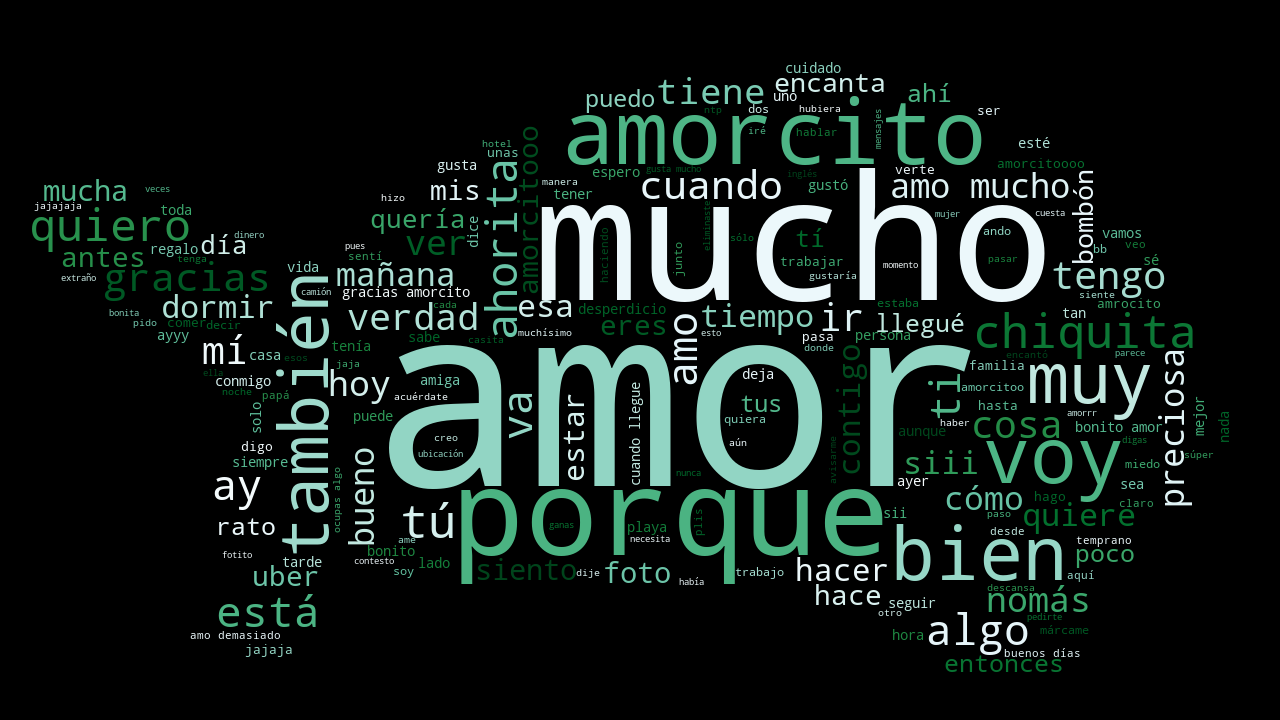

In [76]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Multimedia', 'omitido',
                              'y', 'mi', 'o', 'q', 'yo', 'al', 'editó', 'mensaje', 'eliminó', 'ni', 'fue', 'ere', 'sin', 'ese', 'estoy', 'ves', 'tu'])

mask1 = np.array(Image.open('Recursos/Siluetas/tortuga1.jpg'))
mask2 = np.array(Image.open('Recursos/Siluetas/heart.jpg'))

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in word_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud1 = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords,
                      max_words=200, min_font_size = 5,
                      mask = mask1, colormap='BuGn',).generate(total_palabras)

wordcloud2 = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords,
                      max_words=200, min_font_size = 5,
                      mask = mask2, colormap='OrRd',).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud1.to_image()


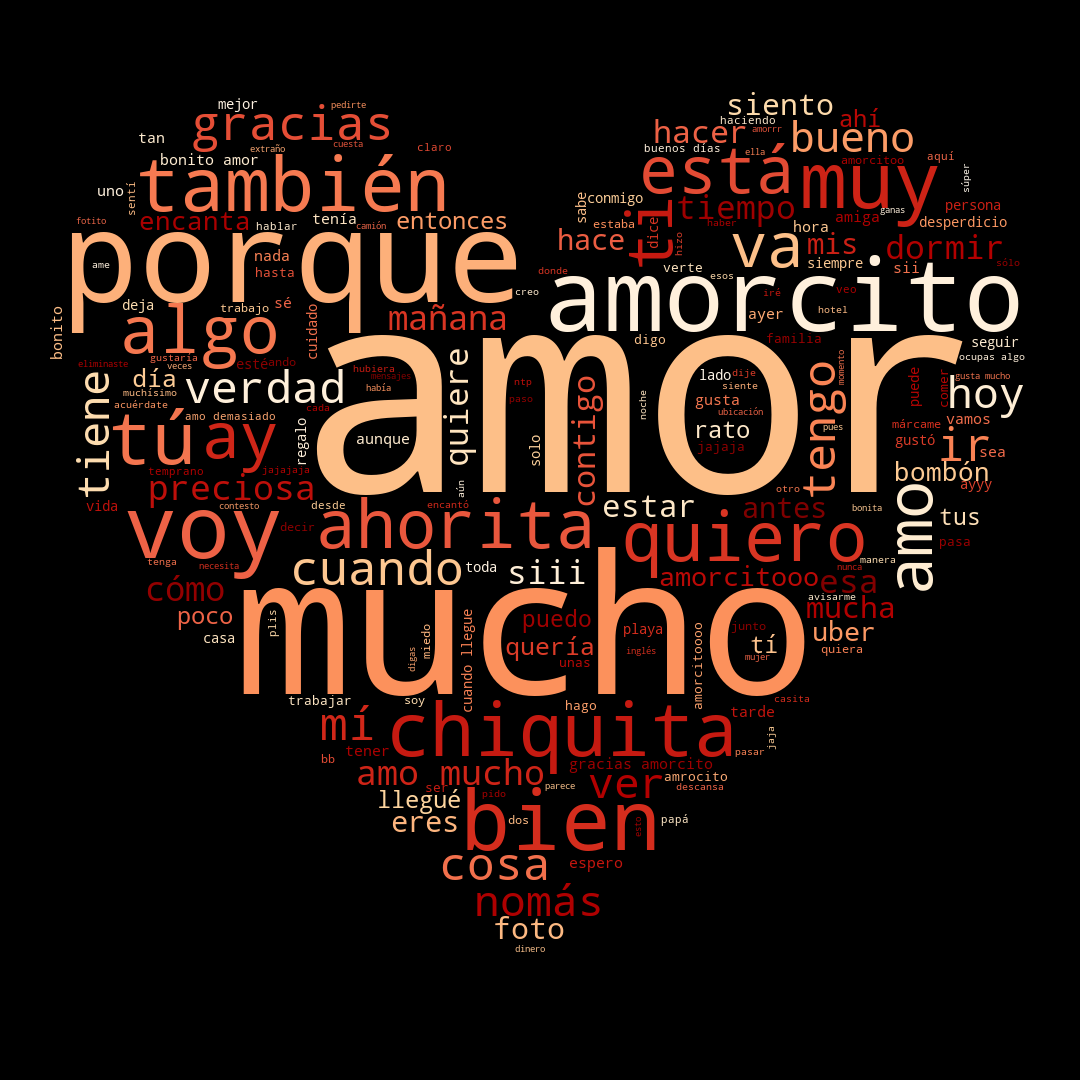

In [77]:
wordcloud2.to_image()